In [85]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder


from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

print(tf.__version__)
print(device_lib.list_local_devices())

def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward


def reward_heat(temp):
    reward = np.exp(-((temp-29)**2)/(2*2**2))
    return reward

## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0
data['heat'] = 0


data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0
data.loc[data[data.index.dayofweek == 5].index,['heat']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0
data.loc[data[data.index.dayofweek == 6].index,['heat']] = 0

room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_room = data.loc[:,['temp','co2','site_details','vent','heat','people']]

for i in room_list:
    room_name = i
    dataset = data_room.loc[data_room.site_details == room_name,:][['temp','co2','vent','heat','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'temp_t+1'] = dataset.loc[:,'temp'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward_co2'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'reward_heat'] = dataset.loc[:,'temp_t+1'].map(lambda x : reward_heat(x))
    dataset.loc[:,'done'] = 0
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = 1
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:][['co2','temp','people','co2_t+1','temp_t+1','people_t+1','reward_co2','reward_heat','vent','heat','done',]]

# dense model 만드는 함수
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

# multi_agent structure 만드는 함수
def build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape):
    actor_list = []
    critic_qnet_list = []
    critic_qnet_target_list = []
    for i in range(agent_num):
        actor_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_target_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
    return actor_list, critic_qnet_list, critic_qnet_target_list


def get_action(actor,state, num_samples: int = 3):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    
    mean_q = tf.concat([tf.reshape(tf.gather(qs[i],sampled_as[i], axis=0),[1,-1]) for i in range(len(qs))],axis=0)
    mean_q = tf.math.reduce_mean(mean_q,axis=1,keepdims=True)
    return mean_q

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17376229495296190425
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 869828608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15514637183383173000
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
c:\Users\Go\OneDrive - UOS\allrepos\multi_agent_awac
['남부', '동화나라', '소리엘', '솜사탕', '예나']


C:\Users\Go\AppData\Local\Temp\ipykernel_20212\77565687.py:63: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_20212\77565687.py:64: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_20212\77565687.py:65: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['heat']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_20212\77565687.py:90: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = 1
C:\Users\Go\AppDat

In [87]:
@tf.function()
def train_critic_step(s,ns,a,r,done):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    qs = critic_qnet_target(ns)
    sampled_as = get_action(actor,ns, num_action_samples)
    mean_qsa = get_mean_qsa(qs,sampled_as)
    q_target = r + gamma * mean_qsa * (1 - done)
    # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
    q_val = tf.reshape(tf.gather_nd(critic_qnet(s),a,batch_dims=1,),[-1,1])
    loss = loss_fun(q_val, q_target)
  grads = tape.gradient(loss, critic_qnet.trainable_variables)
  optimizer.apply_gradients(zip(grads, critic_qnet.trainable_variables))
  # target net soft update
  soft_g = [(b-a)*tau for a,b in zip(critic_qnet_target.trainable_variables, critic_qnet.trainable_variables)]
  # soft_g = (np.array(critic_qnet.trainable_variables) - np.array(critic_qnet_target.trainable_variables))*tau
  optimizer.apply_gradients(zip(soft_g, critic_qnet_target.trainable_variables))
  
  
  return loss

@tf.function()
def train_actor_step(s,a,):
  with tf.GradientTape() as tp:
      
      # log_probability 계산
      logits = actor(s)
      m = tfp.distributions.Categorical(logits = logits)
      log_prob = tf.reshape(m.log_prob(tf.squeeze(a)),[-1,1])
      
      #가중치항 계산
      qs = critic_qnet_target(s)
      action_probs = tf.nn.softmax(logits, axis=None, name=None)
      vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
      qas = tf.reshape(tf.gather_nd(qs,a,batch_dims=1,),[-1,1])
      adv = qas - vs
      weight_term = tf.math.exp((1/lam*adv), name=None)
      
      #loss
      loss = tf.math.reduce_mean(log_prob * weight_term*-1)
      
  actor_grad = tp.gradient(loss, actor.trainable_variables)
  optimizer.apply_gradients(zip(actor_grad, actor.trainable_variables))
  # train_accuracy.update_state(labels, predictions)
  
  return loss

In [25]:
# room_sync_list = ['솜사탕_거실.csv']
room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index

for i in room_sync_list:
    temp_data = data_by_room[i].loc[row_ind]
    #스케일링
    scaler = MinMaxScaler()
    co2_minmax = scaler.fit_transform(temp_data.values[:,[0,],])


    s.append(tf.convert_to_tensor(co2_minmax,dtype=tf.float32))
    ns.append(tf.convert_to_tensor(temp_data.values[:,[3,],],dtype=tf.float32))

    a_list.append(tf.convert_to_tensor(temp_data.values[:,[8],],dtype=tf.int64))

    r_list.append(tf.convert_to_tensor(temp_data.values[:,[6],],dtype=tf.float32))

#정규화 레이어
# layer = tf.keras.layers.Normalization(axis=1)
# layer.adapt(s[0])

#데이터셋 제작
# s_dataset = tf.data.Dataset.from_tensor_slices(layer(s[0]))
# ns_dataset = tf.data.Dataset.from_tensor_slices(layer(ns[0]))
s_dataset = tf.data.Dataset.from_tensor_slices(s[0])
ns_dataset = tf.data.Dataset.from_tensor_slices(ns[0])

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[10]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset),(a2_dataset,r2_dataset),),done_dataset))
# train_dataset.element_spec

In [147]:
room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']
scaler = MinMaxScaler()
def reward(co2_list, col_num):
    reward = 0
    for i in range(col_num):
        reward += np.exp(-((co2_list[:,i]-900)**2)/(2*350**2))
    reward = reward/col_num
    return reward


############################## train set ##############################
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']
start_date = '2022-01-04'
end_date = '2022-01-27'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index

#
state_culnames = ['co2']
next_state_culnames = ['co2_t+1']
action_culnames = ['vent']

s_list = []
ns_list = []
a_list = []

for i in room_sync_list:
    
    s_list.append(data_by_room[i].loc[row_ind][state_culnames].values)
    ns_list.append(data_by_room[i].loc[row_ind][next_state_culnames].values)
    a_list.append(data_by_room[i].loc[row_ind][action_culnames].values)

s = np.concatenate(s_list,axis=1)
ns = np.concatenate(ns_list,axis=1)
a = np.concatenate(a_list,axis=1)
r = reward(s, 2).reshape([-1,1])
done = data_by_room[i].loc[row_ind][['done']].values

# 스케일링
scaler.fit(s)
s = scaler.transform(s)
ns = scaler.transform(ns)

# # one-hot encoding
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(a)
# a = enc.transform(a).toarray()

#학습용 데이터세트 제작
s_ds = tf.data.Dataset.from_tensor_slices(s)
ns_ds = tf.data.Dataset.from_tensor_slices(ns)
a_ds = tf.data.Dataset.from_tensor_slices(a)
r_ds = tf.data.Dataset.from_tensor_slices(r)
done_ds= tf.data.Dataset.from_tensor_slices(done)

train_dataset = tf.data.Dataset.zip((s_ds,ns_ds,a_ds,r_ds,done_ds))
##########################################################################




In [153]:
#################set params!################
# params of multi_AWAC
hidden_structure= [64, 128, 256, 128, 64]
input_shape= 2
output_shape= 2
act_function= 'relu'
lam = 1
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()
############################################
# 초기 모델 생성
actor = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
critic_qnet = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
critic_qnet_target = make_dense_model(hidden_structure,input_shape,act_function,output_shape)

critic_qnet_target.set_weights(critic_qnet.get_weights())

In [154]:
%%time
# 학습 루프 관련
batch_size = 1024
buffer_len = len(train_dataset)
# n_train = 10
n_run = 300

#
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

# 
critic_loss = []
actor_loss = []

dat = shuffled_dataset.batch(batch_size).take(1).repeat(n_run)
for batch in tqdm(dat):
    
    s = batch[0]
    ns = batch[1]
    a = batch[2]
    r = batch[3]
    done = batch[4]
    break
    critic_loss.append(train_critic_step(s,ns,a,r,done))
    actor_loss.append(train_actor_step(s,a))

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: total: 31.2 ms
Wall time: 37 ms


In [ ]:
# log_probability 계산
logits = actor(s)
m = tfp.distributions.Categorical(logits = logits)
log_prob = tf.reshape(m.log_prob(tf.squeeze(a)),[-1,1])

#가중치항 계산
qs = critic_qnet_target(s)
action_probs = tf.nn.softmax(logits, axis=None, name=None)
vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
qas = tf.reshape(tf.gather_nd(qs,a,batch_dims=1,),[-1,1])
adv = qas - vs
weight_term = tf.math.exp((1/lam*adv), name=None)

#loss
loss = tf.math.reduce_mean(log_prob * weight_term*-1)

In [156]:
a

<tf.Tensor: shape=(1024, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)>

In [157]:
logits

<tf.Tensor: shape=(1024, 2), dtype=float32, numpy=
array([[2.9034647e-03, 6.5165078e-03],
       [1.0716999e-03, 2.5467738e-03],
       [1.8857371e-03, 4.2326711e-03],
       ...,
       [7.4067386e-05, 1.6049470e-04],
       [4.7120722e-03, 1.0609836e-02],
       [2.8933366e-03, 6.4977896e-03]], dtype=float32)>

In [168]:
m.log_prob([1])

<tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([-0.6913423 , -0.69240993, -0.6919744 , ..., -0.693104  ,
       -0.69020265, -0.6913466 ], dtype=float32)>

In [132]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(a)
enc.transform(a).toarray()

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       ...,
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

In [146]:
enc.inverse_transform([[0,1,0,1]])

array([[1, 1]], dtype=int64)

In [133]:
a

<tf.Tensor: shape=(1024, 2), dtype=int64, numpy=
array([[1, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)>

In [131]:
enc.transform(a).toarray()

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       ...,
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

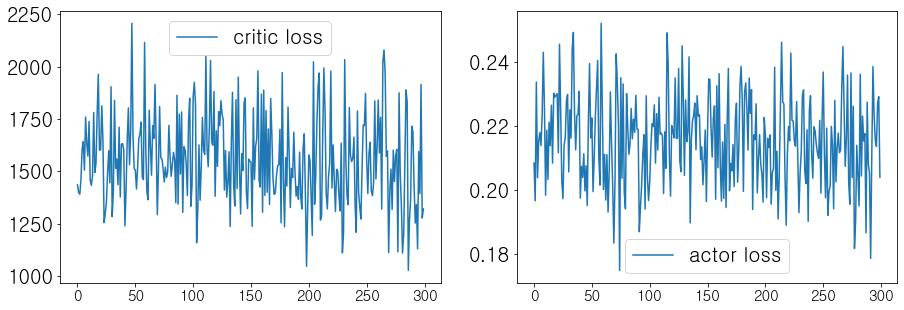

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(critic_loss, label='critic loss')
axes[0].legend()
axes[1].plot(actor_loss, label='actor loss')
axes[1].legend()

In [21]:
room_sync_list = ['솜사탕_거실.csv']


s = []

start_date = '2022-02-21'
end_date = '2022-02-24'

len_list = []
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    len_notna = len(temp_data.dropna())
    len_list.append(len_notna)
max_na_room = room_sync_list[np.argmin(len_list)]
row_ind = data_by_room[max_na_room].loc[start_date:end_date].dropna().index


# attention state set 제작
test_action_set_list = []

temp_data = data_by_room['솜사탕_거실.csv'].loc[row_ind]
test_action_set_list.append(temp_data)
s.append(tf.convert_to_tensor(temp_data.values[:,[0,],],dtype=tf.float32))


s = tf.concat(s,axis=1)
scaled_s = scaler.transform(s)
# state-action set 제작
testset_action = actor(scaled_s)
test_action_set_list[0]['testset_a_vent'] = tf.math.argmax(testset_action,axis=1,output_type=tf.dtypes.int64,name=None).numpy()


CPU times: total: 62.5 ms
Wall time: 53 ms


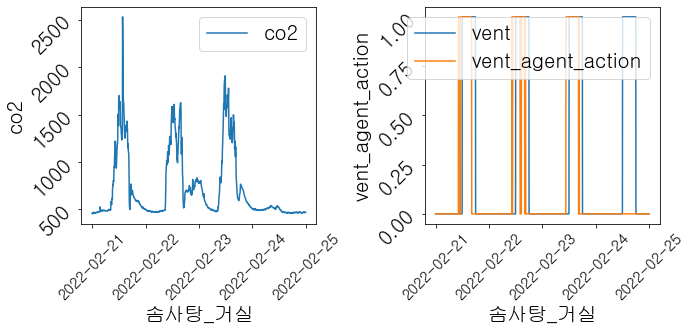

In [22]:
%%time
fig, axes = plt.subplots(1,2, figsize=(10,5))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)


p_data = test_action_set_list[0]

axes[0].plot(p_data.loc[:,'co2'], label = 'co2')
axes[0].set_ylabel('co2')
axes[0].legend()
axes[0].set_xlabel('솜사탕_거실')
axes[0].tick_params(labelrotation=45)
axes[0].xaxis.set_major_locator(dates.DayLocator())


axes[1].plot(p_data.loc[:,'vent'], label = 'vent')
axes[1].set_ylabel('vent')
axes[1].legend()
axes[1].set_xlabel('솜사탕_거실')
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator())

axes[1].plot(p_data.loc[:,'testset_a_vent'], label = 'vent_agent_action')
axes[1].set_ylabel('vent_agent_action')
axes[1].legend()
axes[1].set_xlabel('솜사탕_거실')
axes[1].tick_params(labelrotation=45)
axes[1].xaxis.set_major_locator(dates.DayLocator())


plt.tight_layout()